# **Finding Lane Lines on the Road** 
***
Random text...
---
The steps for the project is:
1.    Camera calibration
2.    Distortion correction
3.    Color/gradient threshold
4.    Perspective transform

Thereafter:

-    Detect lane lines
-    Determine the lane curvature
-    Determine the vehicle position in the lane



**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

# **Import needed packages**
---
Run the following cell to import all packages needed for the project

In [1]:
# Import some useful packages

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import pickle

%matplotlib inline

# **Calibrating the camera** 
***
The camera is calibrated by using the chessboard images in the camera_cal folder.
---
The steps of calibration are:
* Find chessboard corners
* Calibrate camera based on object points and image points

---
**Note that calibration only needs to be done once. The calibration data is saved and can be loaded in the undistortion instead of redoing the calibration.**

In [ ]:
# Find the chessboard corners

# define number of rows and columns in calibration images
nx = 9
ny = 6

# arrays to store object points and image points of all images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# create list of calibration images
testImages = glob.glob("camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(testImages):
    # Load image
    img = mpimg.imread(fname)
    # Gray scale (BGR since using opencv load function)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        '''
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        '''

#cv2.destroyAllWindows()


In [ ]:
# Calibrate camera

# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration_dist_pickle.p", "wb"))


# **Undistorting image**

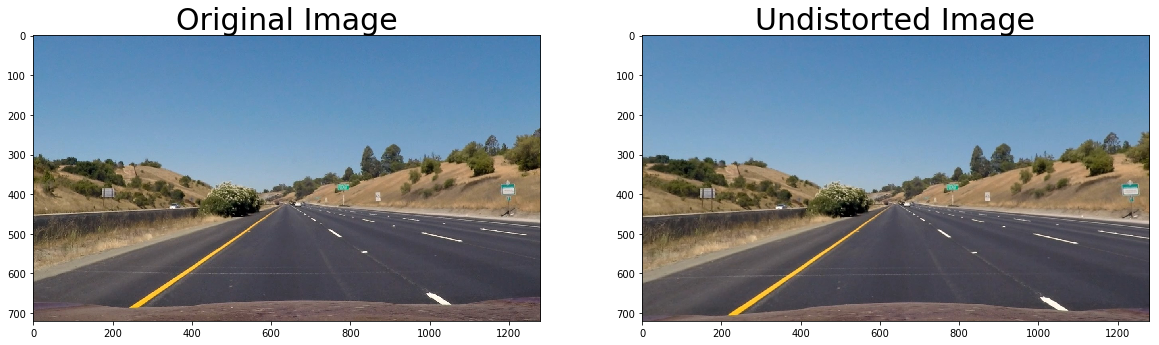

In [2]:
# Undistort image

# Load camera calibration
dist_pickle = pickle.load(open("camera_cal/calibration_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Load image for distortion
img = mpimg.imread('test_images/straight_lines1.jpg')

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('test_images/straight_lines1_undst.jpg')

# **Color/gradient thresholding**
***
To determine where the lane markings are we will need to make sure to find them properly, being able to detect all kinds of lane markings and in all kinds of situations.
---

Steps considered:
- 
- 


In [3]:
# Functions to be used for thresholding

# Function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelxy = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobelxy = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    absSobel = np.absolute(sobelxy)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    bitSobel = np.int8(255*absSobel/np.max(absSobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sxbinary = np.zeros_like(bitSobel)
    sxbinary[(bitSobel >= thresh[0]) & (bitSobel <= thresh[1])] = 1
    return sxbinary

# Function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude
    sobel_mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    intSobel = np.int8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(intSobel)
    binary_output[(intSobel >= mag_thresh[0]) & (intSobel <= mag_thresh[1])] = 1
    return binary_output

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

def binary_S(S_image, thresh=(0,255)):
    binary = np.zeros_like(S_image)
    binary[(S_image > thresh[0]) & (S_image <= thresh[1])] = 1
    
    return binary


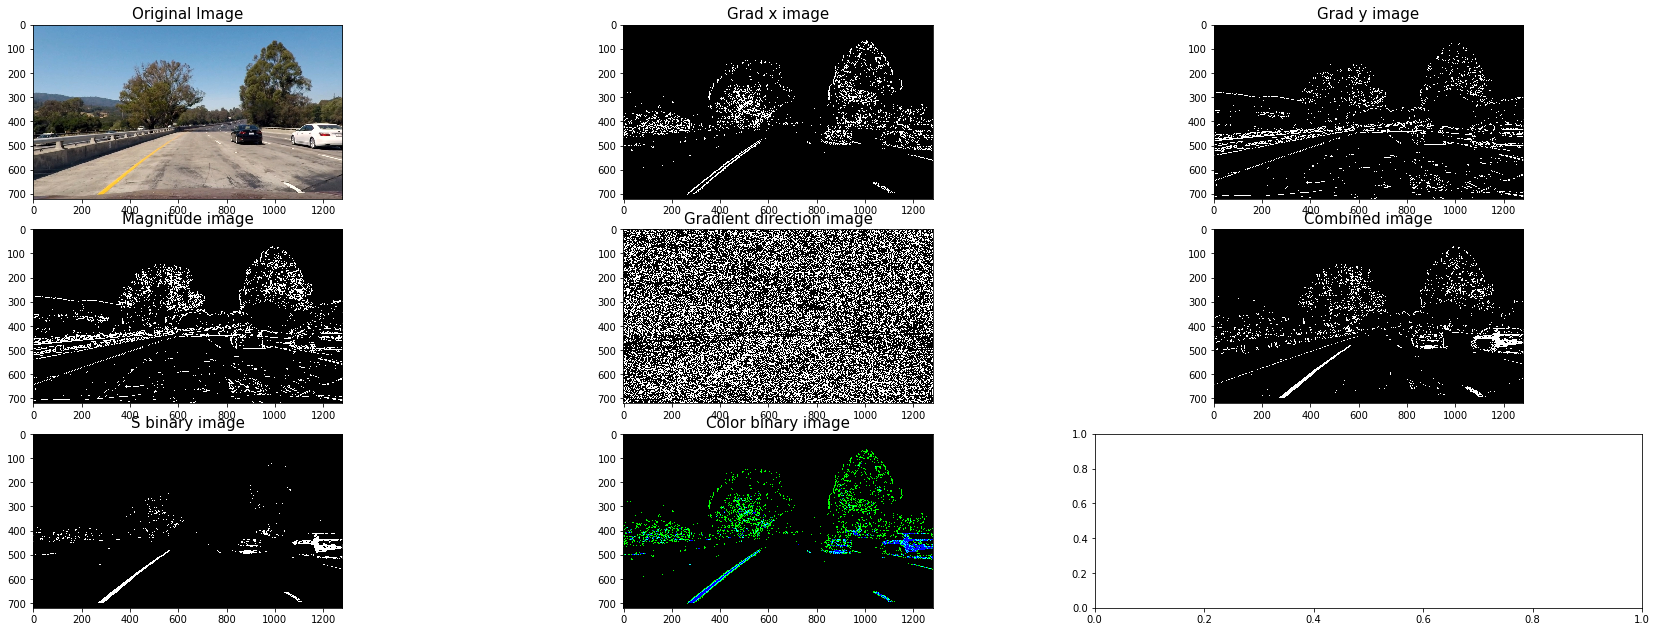

In [67]:
# Perform combined thresholding


# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Read in an image
img = mpimg.imread('test_images/test1.jpg')

# Perform image undistortion
image = cv2.undistort(img, mtx, dist, None, mtx)

# Convert image to chosen colour spaces
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
S = HLS[:,:,2]
R = image[:,:,0]

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(R, orient='x', sobel_kernel=ksize, thresh=(30,100))
grady = abs_sobel_thresh(R, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(R, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(R, sobel_kernel=ksize, thresh=(0.7, 1.3))
s_binary = binary_S(S,(170,255))
gradxS = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(20,100))
gradyS = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(30,100))
mag_binaryS = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(30,100))
dir_binaryS = dir_threshold(S, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Combine thresholding functions
combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[(gradx == 1) | (s_binary == 1)] = 1

color_binary = np.dstack(( np.zeros_like(gradx), gradxS, s_binary))


# Plot the result
f, axes = plt.subplots(3, 3, figsize=(24, 9))
f.tight_layout()
axes[0,0].imshow(image)
axes[0,0].set_title('Original Image', fontsize=15)
axes[0,1].imshow(gradxS, cmap='gray')
axes[0,1].set_title('Grad x image', fontsize=15)
axes[0,2].imshow(grady,cmap='gray')
axes[0,2].set_title('Grad y image',fontsize=15)
axes[1,0].imshow(mag_binary,cmap='gray')
axes[1,0].set_title('Magnitude image',fontsize=15)
axes[1,1].imshow(dir_binary,cmap='gray')
axes[1,1].set_title('Gradient direction image',fontsize=15)
axes[1,2].imshow(combined,cmap='gray')
axes[1,2].set_title('Combined image',fontsize=15)
axes[2,0].imshow(s_binary,cmap='gray')
axes[2,0].set_title('S binary image',fontsize=15)
axes[2,1].imshow(color_binary,cmap='gray')
axes[2,1].set_title('Color binary image',fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

***
Perform extra image processing
--- 
To get rid of unneccessary information

In [68]:
# Functions used for extra image processing

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

[[[ 100  720]
  [ 620  410]
  [ 680  410]
  [1230  720]]]


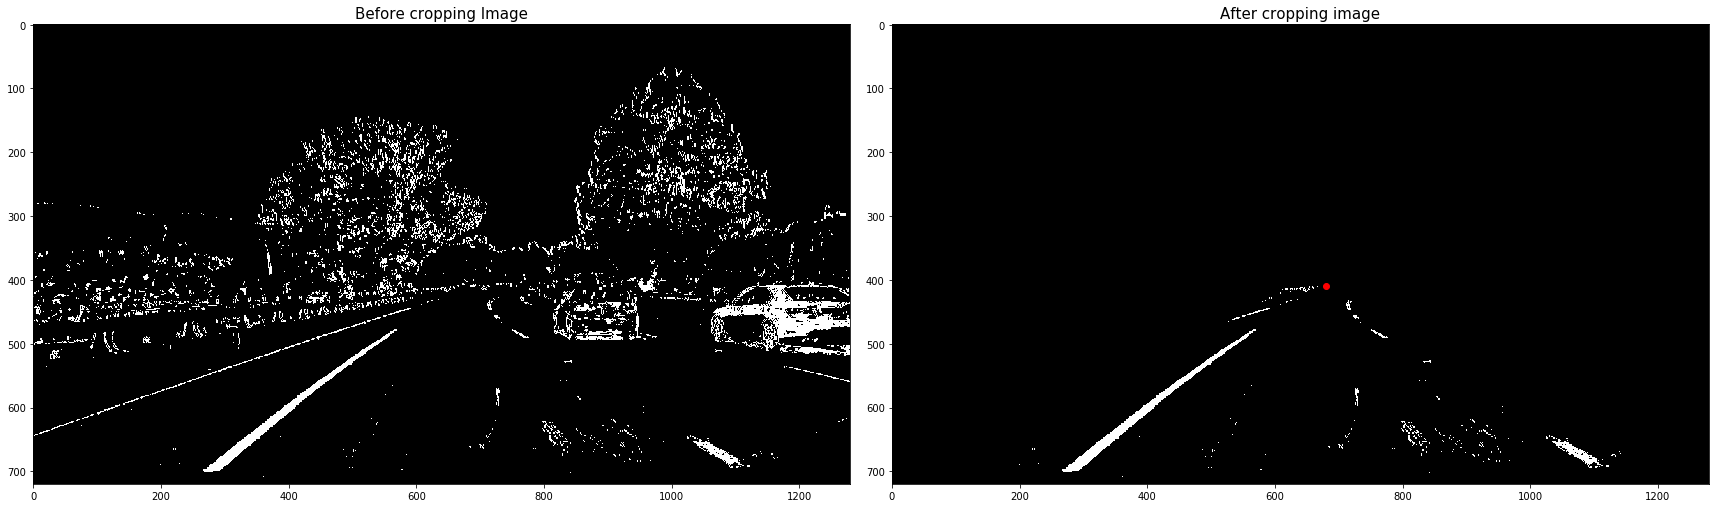

In [69]:
# Process image further

# only region of interest
imshape = np.shape(combined)
vertices = np.array([[(100,imshape[0]),(imshape[1]/2-20,imshape[0]/2+50),(imshape[1]/2+40,imshape[0]/2+50),(imshape[1]-50,imshape[0])]], dtype=np.int32)
masked_combined = region_of_interest(combined,vertices)
print(vertices)

# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(combined, cmap='gray')
axes[0].set_title('Before cropping Image', fontsize=15)
axes[1].imshow(masked_combined, cmap='gray')
axes[1].set_title('After cropping image', fontsize=15)
axes[1].plot(680,410,'ro')

#750

# **Perspective Transform**
---
The perspective transform is based on a lane image with straight lines. In this image points on the lane lines were chosen as source points. 


(720, 1280)


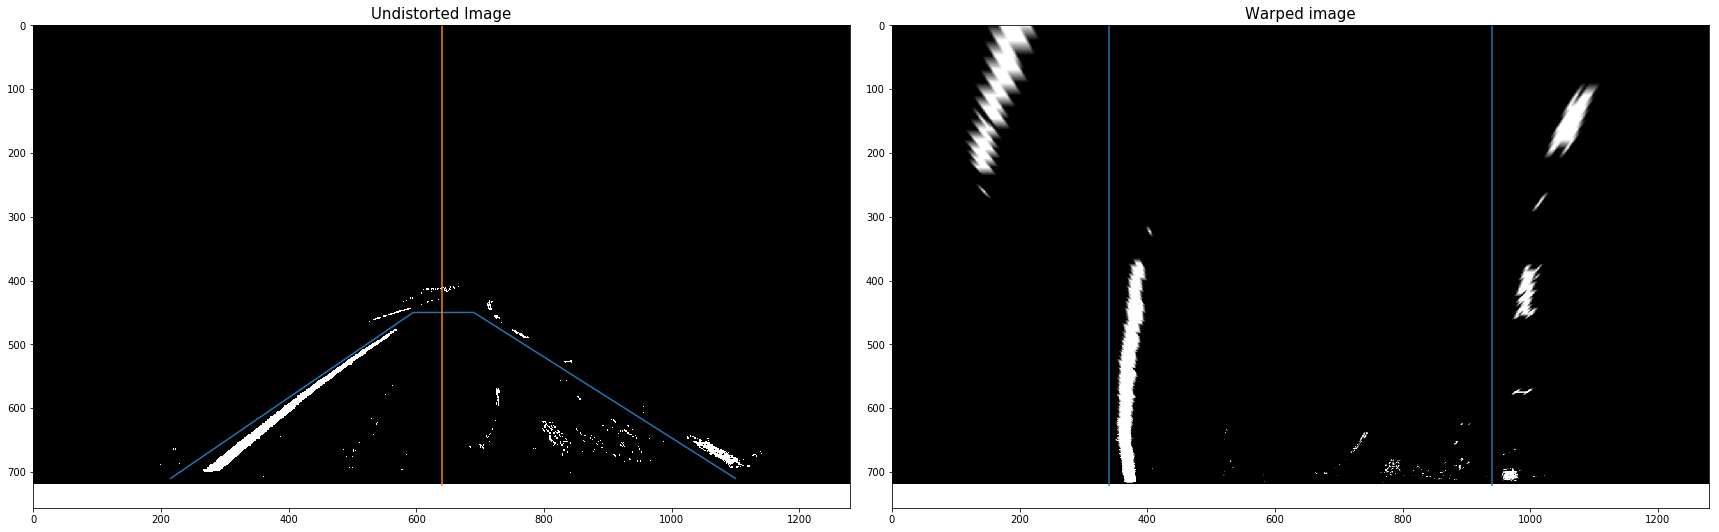

In [70]:


# image should be combined image from thresholding

# gaussian blur image  (move to previous cell)

#canny edge detection? hough transform?

# load image and undistort
#img = mpimg.imread('test_images/straight_lines2.jpg')
#undist_img = cv2.undistort(img, mtx, dist, None, mtx)

ref_right = 940 # reference value for right lane marking
ref_left = 340 # reference value for left lane marking

undist_img = masked_combined

# use straight camera image to find points, use these for all images
src = np.float32([[215, 710], [595, 450], [690, 450], [1100, 710]])
dst = np.float32([[ref_left,np.shape(undist_img)[0]], [ref_left,0], [ref_right,0], [ref_right,np.shape(undist_img)[0]]])

# Compute perspective transform
M = cv2.getPerspectiveTransform(src, dst)
print(np.shape(undist_img))

# Warp the image
warped = cv2.warpPerspective(undist_img, M, (np.shape(undist_img)[1],np.shape(undist_img)[0]), flags=cv2.INTER_LINEAR)

f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(undist_img,cmap='gray')
axes[0].set_title('Undistorted Image', fontsize=15)
# Plot additional points to check what to use for perspective transform
axes[0].plot([215,595,690,1100], [710,450,450,710])
axes[0].plot([640, 640],[0,720])
#plt.show()
axes[1].imshow(warped,cmap='gray')
axes[1].set_title('Warped image', fontsize=15)
axes[1].plot([ref_left,ref_left,ref_right,ref_right], [np.shape(undist_img)[0],0,0,np.shape(undist_img)[0]])
#axes[1].plot(360,720,'ro')

# **Detect lane lines and find equation**
***

Using histogram method to find lane lines and a second order polonomial to find equation.

In [71]:

        
histogram = np.sum(warped[np.int32(warped.shape[0]/2):,:], axis=0)
#plt.plot(histogram)

# Create an output image to draw on and visualize the result
# Transform value range to 0-255
warped_copy = np.uint8(warped*255)
# Create 3-channel image to be able to draw colour
out_img = cv2.cvtColor(warped_copy, cv2.COLOR_GRAY2RGB)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)



(720, 0)

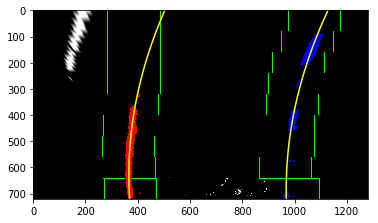

In [72]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [73]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "warped")
# It's now much easier to find line pixels!
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

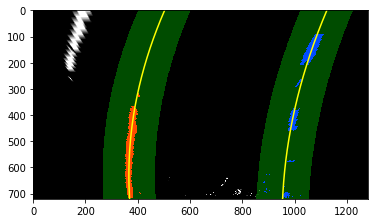

In [74]:
# Create an image to draw on and an image to show the selection window
warped_copy = np.uint8(warped*255)
# Create 3-channel image to be able to draw colour
out_img = cv2.cvtColor(warped_copy, cv2.COLOR_GRAY2RGB)

window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# ***Determine lane curvature and vehicle position***
***


In [75]:
# Determine vehicle position

lane_w_pxls = ref_right-ref_left
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/lane_w_pxls # meters per pixel in x dimension (pixels is lane width in warped image)


# middle of lane should be in the middle of the image (camera is assumed to be centered in vehicle)
norm_middle = warped.shape[1]/2
print(norm_middle)

diff_right = rightx_base-norm_middle-lane_w/2

if diff_right > 0:
    # we are located to the left
    print(np.absolute(diff_right)*xm_per_pix, 'm to the left of middle') #make conversion to get in m
elif diff_right < 0:
    # we are located to the right
    print(np.absolute(diff_right)*xm_per_pix, 'm to the right of middle') #make conversion to get in m
else:
    # we are located in the middle
    print('in the middle') 
    

640.0
0.333 m to the left of middle


In [76]:
# Determine lane curvature based on vehicle position

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = warped.shape[0]    

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

408.38243139 m 534.021708968 m


# ** Convert back to original view**

(1, 720, 2)
(1, 1440, 2)


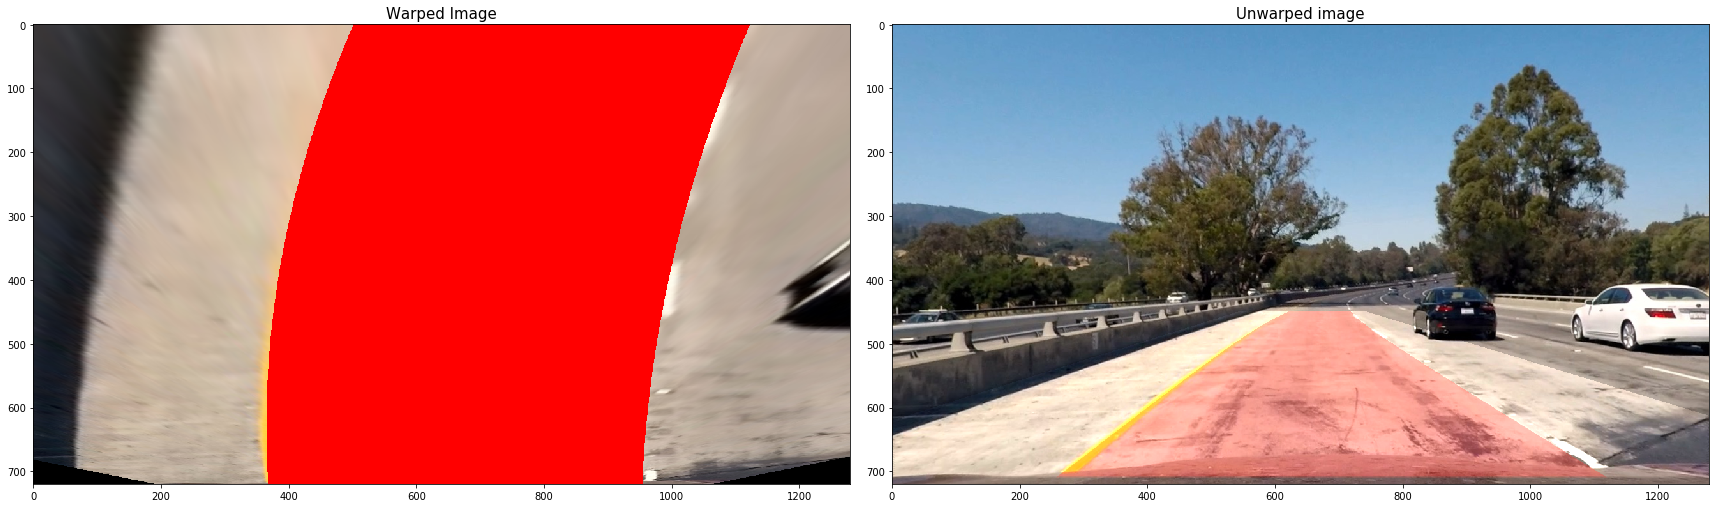

In [77]:
# image is undistorted image, this is the image to draw on
# First warp it
warped_out = cv2.warpPerspective(image, M, (np.shape(image)[1],np.shape(image)[0]), flags=cv2.INTER_LINEAR)

# Draw lines on it
xy_plot_left = np.zeros((1,np.shape(ploty)[0],2))
xy_plot_left[:,:,0] = left_fitx
xy_plot_left[:,:,1] = ploty

xy_plot_right = np.zeros((1,np.shape(ploty)[0],2))
xy_plot_right[:,:,0] = right_fitx
xy_plot_right[:,:,1] = ploty

xy_plot = np.zeros((1,np.shape(ploty)[0]*2,2))
xy_plot[:,0:np.shape(ploty)[0],0] = left_fitx
xy_plot[:,0:np.shape(ploty)[0],1] = ploty
xy_plot[:,np.shape(ploty)[0]:,0] = right_fitx[::-1]
xy_plot[:,np.shape(ploty)[0]:,1] = ploty[::-1]


#np.array([[left_fitx, ploty],[right_fitx, ploty]])

print(xy_plot_left.shape)
print(right_line_pts.shape)

#cv2.polylines(warped_out, np.int_(xy_plot_left),True,(255,0,0),30) #add left line
#cv2.polylines(warped_out, np.int_(xy_plot_right),True,(255,0,0),30) #add right line 
cv2.fillConvexPoly(warped_out, np.int_(xy_plot), (255,0,0))


# Compute inverse perspective transform
invM = cv2.getPerspectiveTransform(dst, src)

# Unwarp the image
unwarped = cv2.warpPerspective(warped_out, invM, (np.shape(warped_out)[1],np.shape(warped_out)[0]), flags=cv2.INTER_LINEAR)

# Put image together
result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)

f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(warped_out)
axes[0].set_title('Warped Image', fontsize=15)
axes[1].imshow(result)
axes[1].set_title('Unwarped image', fontsize=15)


# **Setting up project structure**

In [ ]:
# Before starting, setup needed once

# Load camera calibration
dist_pickle = pickle.load(open("camera_cal/calibration_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [ ]:
# All project base line

def preprocessImage(img,mtx,dist):
    # Preprocess image to find lane markings in all situations
    
    # TUNABLE PARAMETERS
    # Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # PERFORM IMAGE UNDISTORTION
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # PERFORM IMAGE THRESHOLDING    
    # Convert image to chosen colour spaces
    #gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
    HLS = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    R = image[:,:,0]

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(R, orient='x', sobel_kernel=ksize, thresh=(30,100))
    grady = abs_sobel_thresh(R, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(R, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(R, sobel_kernel=ksize, thresh=(0.7, 1.3))
    s_binary = binary_S(S,(170,255))
    gradxS = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(20,100))
    gradyS = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(30,100))
    mag_binaryS = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(30,100))
    dir_binaryS = dir_threshold(S, sobel_kernel=ksize, thresh=(0.7, 1.3))

    # Combine thresholding functions
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1) | (s_binary == 1)] = 1

    #color_binary = np.dstack(( np.zeros_like(gradx), gradxS, s_binary))
    
    
    # USE ONLY REGION OF INTEREST
    imshape = np.shape(combined)
    vertices = np.array([[(100,imshape[0]),(imshape[1]/2-20,imshape[0]/2+50),(imshape[1]/2+40,imshape[0]/2+50),(imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_combined = region_of_interest(combined,vertices)    
    
    return masked_combined

def transformImg(undist_img):
# Function that performs perspective transform on an image

    # Source and distance point from straight camera image, use these for all images
    src = np.float32([[215, 710], [595, 450], [690, 450], [1100, 710]])
    dst = np.float32([[360,np.shape(undist_img)[0]], [360,0], [970,0], [970,np.shape(undist_img)[0]]])

    # Compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image
    warped = cv2.warpPerspective(undist_img, M, (np.shape(undist_img)[1],np.shape(undist_img)[0]), flags=cv2.INTER_LINEAR)

    return warped

def findLaneMarkingsNew(warped):
    # Function to find the lane markings from scratch using Histogram approach
    
    histogram = np.sum(warped[np.int32(warped.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

def findLaneMarkingsCont(warped,left_fit,right_fit):
    # Function to detect lane markings when we already have a starting point from earlier found ones
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

def detCurvature(y_eval,leftx,lefty,rightx,righty):
    # Function to determine lane curvature in meters    
      
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/610 # meters per pixel in x dimension (970-360pixels is lane width in warped image)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [ ]:
# Evaluate images

# Read image
img = mpimg.imread('test_images/test1.jpg')

# Preprocess image to make search for lane markings easier
img_prep = preprocessImage(img,mtx,dist)

# Warp image
img_warped = transformImg(img_prep)

# Find lane markings when none found before
left_fit,right_fit,leftx,lefty,rightx,righty = findLaneMarkingsNew(img_warped)

# If lane markings are already found since before
#left_fit, right_fit = findLaneMarkingsCont(img_warped,left_fit,right_fit):

# Calculate curvature
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = warped.shape[0]
left_curveR, right_curveR = detCurvature(y_eval,leftx,lefty,rightx,righty)

In [ ]:

# Generate x and y values for plotting found lane markings
ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
